<a href="https://colab.research.google.com/github/Isaac-Gregory/House-Pricing-SWD/blob/main/housepricing_noiseanalysis_copy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Dataset

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
from scipy.stats import f_oneway, chi2_contingency
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Implementing linear regression
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

In [ ]:
# Replace the below URL with the 'raw' link of your GitHub CSV file
url = "https://raw.githubusercontent.com/Isaac-Gregory/House-Pricing-SWD/refs/heads/main/train.csv"

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(url)

data.drop(['Id'], axis=1, inplace=True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Split numerical from categorical features
X_train = data.drop(['SalePrice'], axis=1)
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
print(len(cat_cols), len(num_cols))

43 36


## Feature Analysis

### Individual Feature Analysis

In [ ]:
nan_cols = {}

# Printing all features with NaN values
for col, i in data.isnull().sum().items():
  if i > 0:
    print(col, i)
    nan_cols[col] = i

# Investigating NaN values in numerical columns
print("---------------------------")
for col in nan_cols:
  if col in num_cols:
    print(col, nan_cols[col])

LotFrontage 259
Alley 1369
MasVnrType 872
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406
---------------------------
LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


**The following is the analysis of the outputted features:**

LotFrontage 259 - May not have street connected to property (should just be set to 0 for NaN values)

Alley 1369 - May not have alley access

MasVnrType 872 - No veneer

MasVnrArea 8 - ???? (should probably set NaN values to 0)

NO BASEMENT:
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38

Electrical 1 - ????

FireplaceQu 690 - No fireplace

NO GARAGE:
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81

PoolQC 1453 - No Pool

Fence 1179 - No fence

MiscFeature 1406 - No miscellaneous (high amount, but potentially highly predictive)

In [ ]:
# Replacing numerical NaNs with zeros
data['LotFrontage'].fillna(0, inplace=True)
data['MasVnrArea'].fillna(0, inplace=True)

# Since NaNs have a meaning in this dataset, we will make them a string part of the feature
# Convert all NaN in cat_cols to strings
for col in cat_cols:
  data[col].fillna('N/A', inplace=True)

### Categorical Class Distribution Analysis

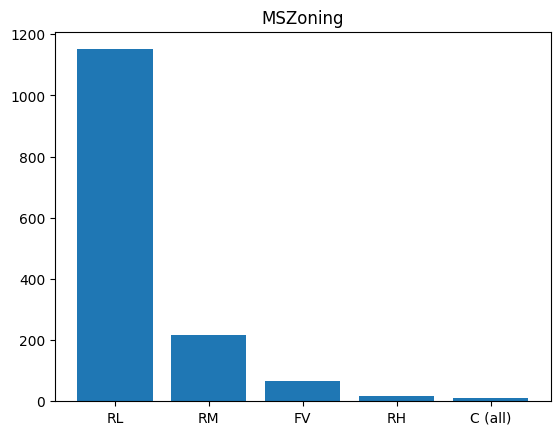

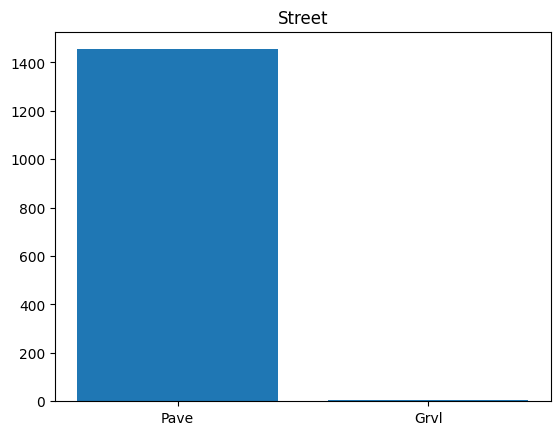

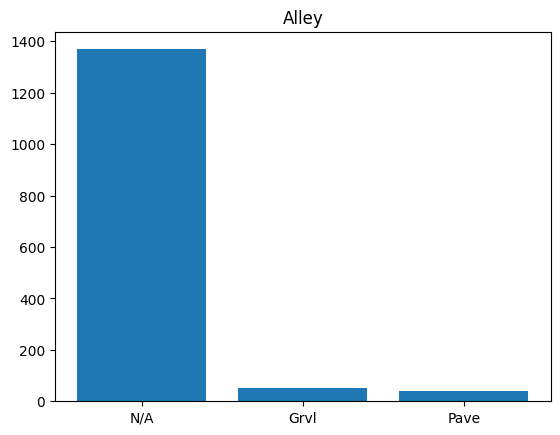

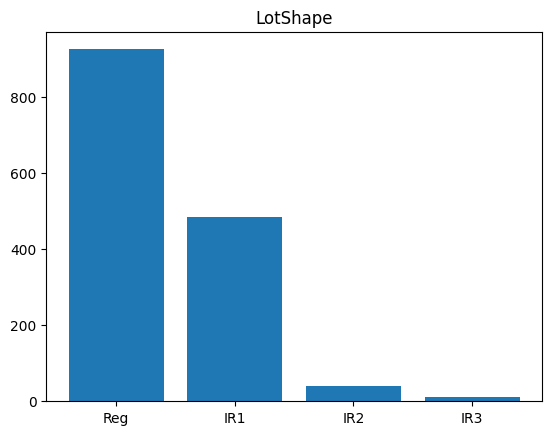

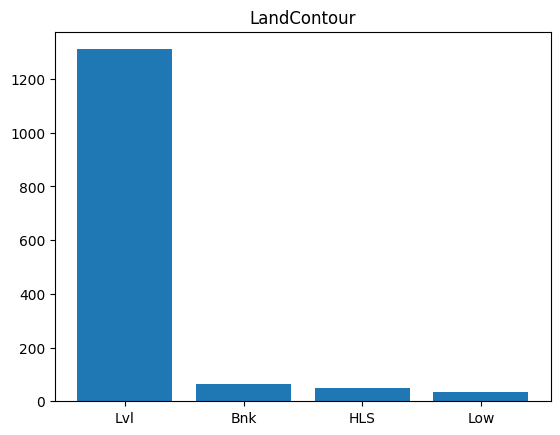

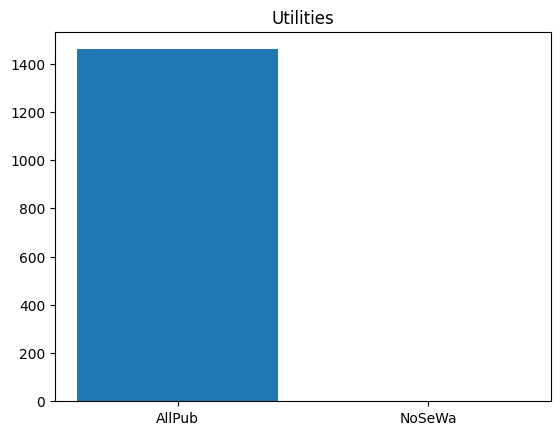

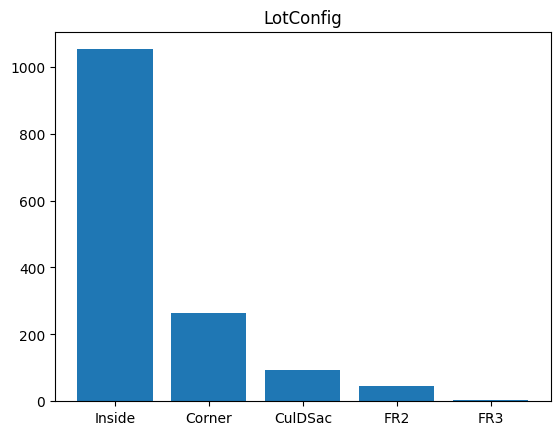

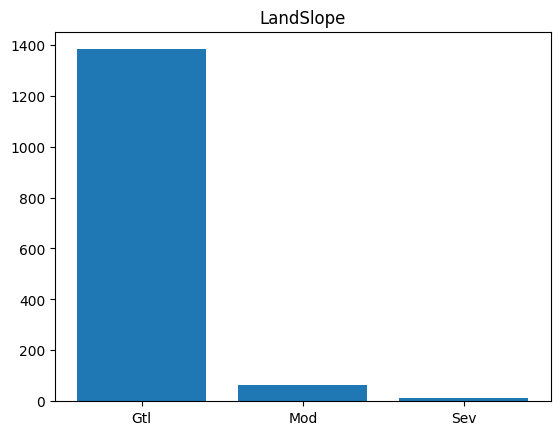

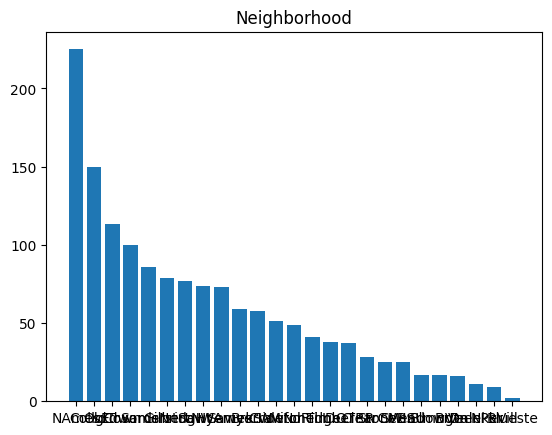

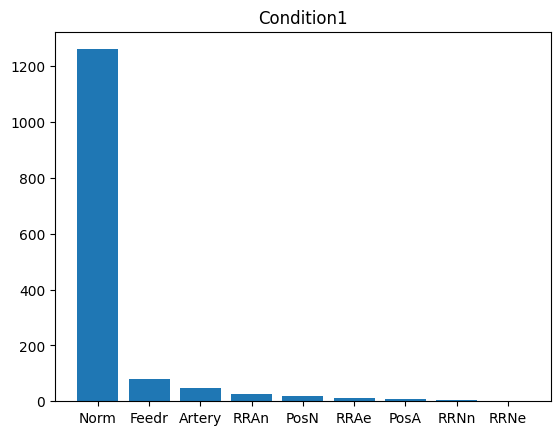

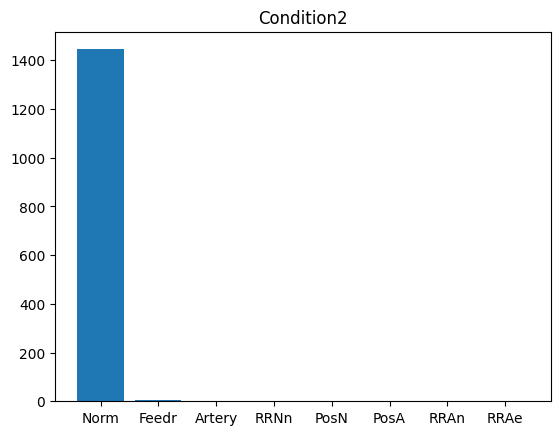

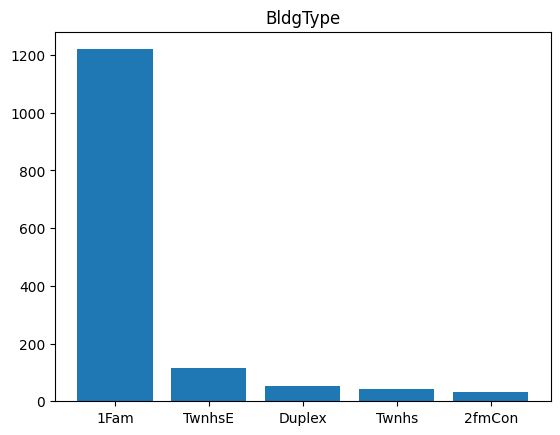

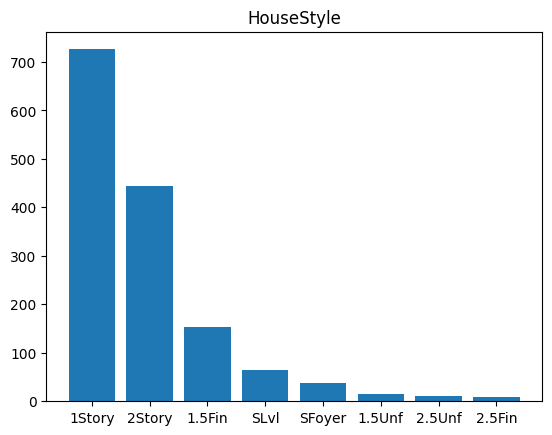

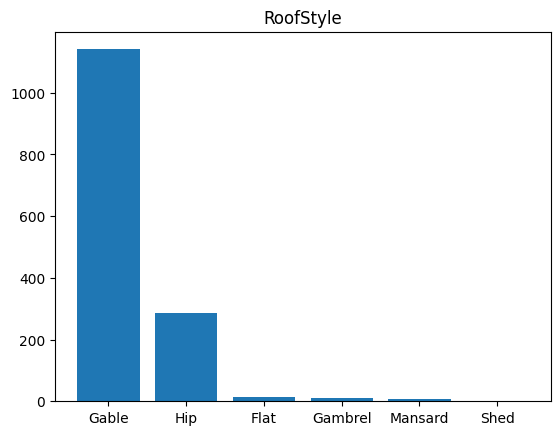

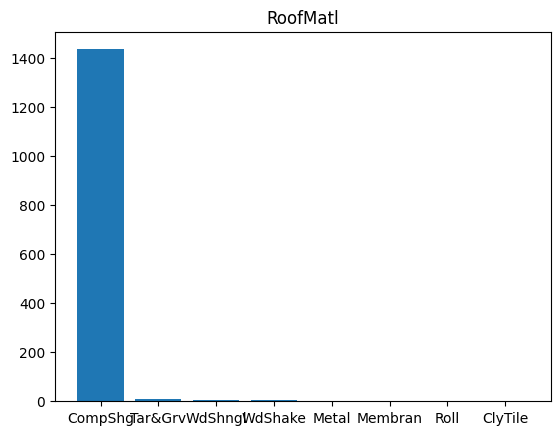

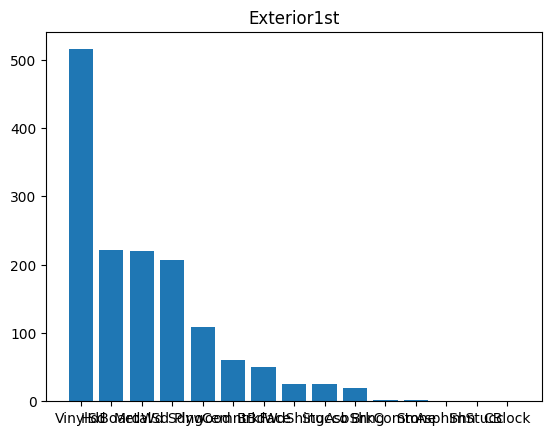

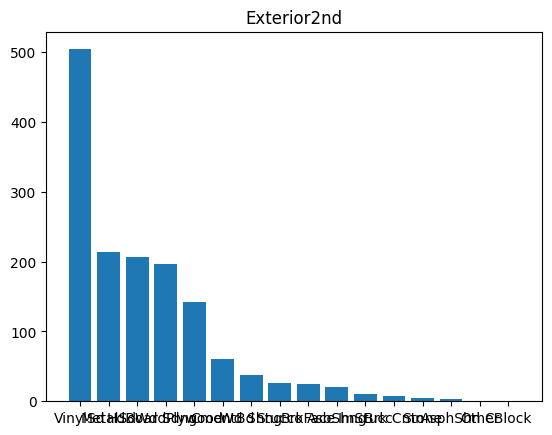

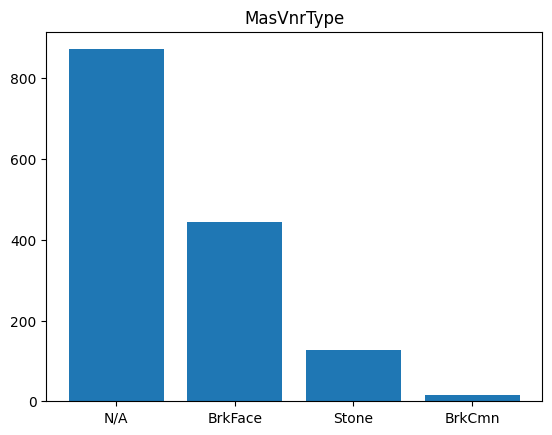

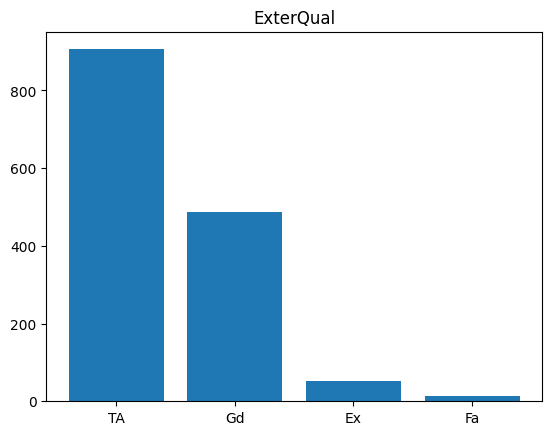

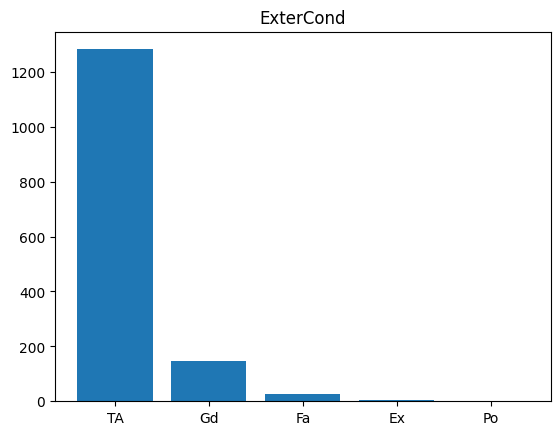

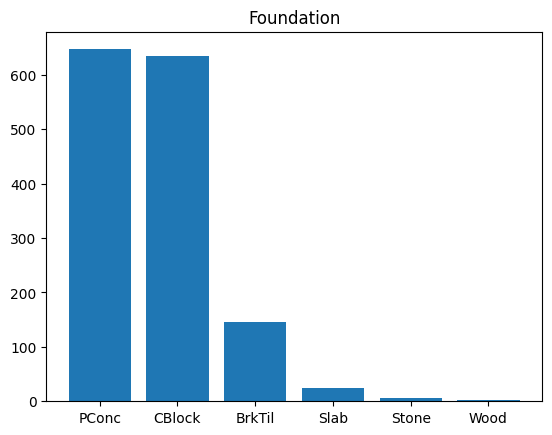

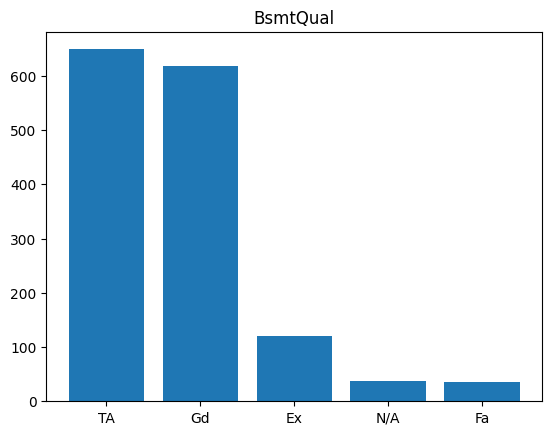

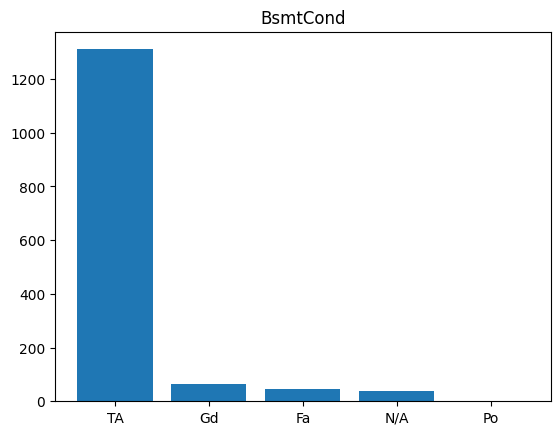

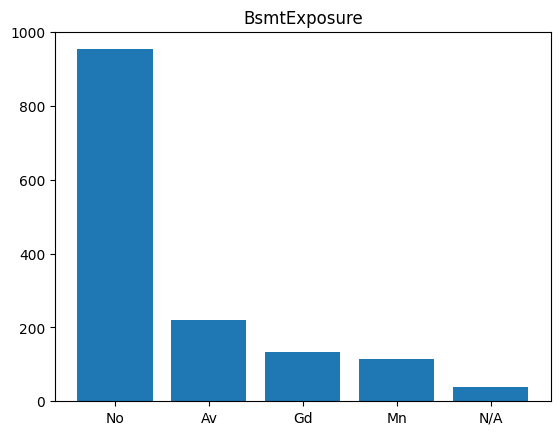

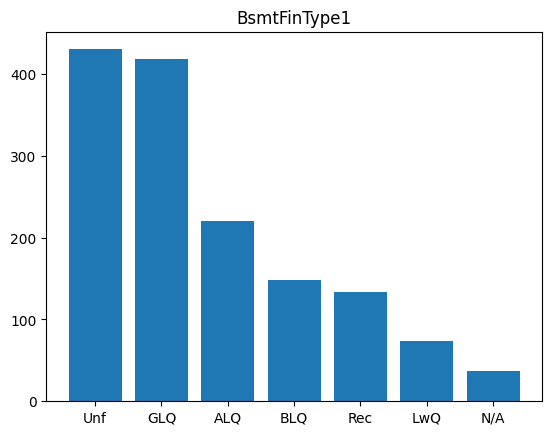

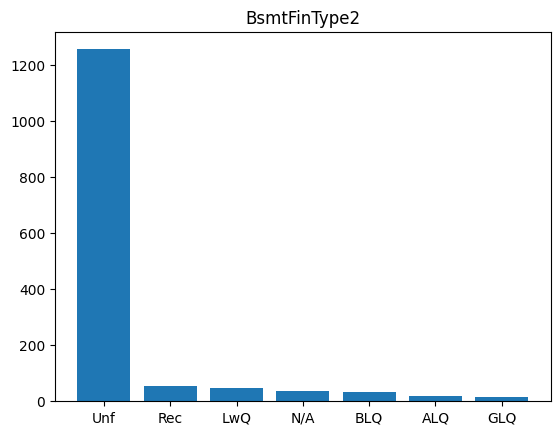

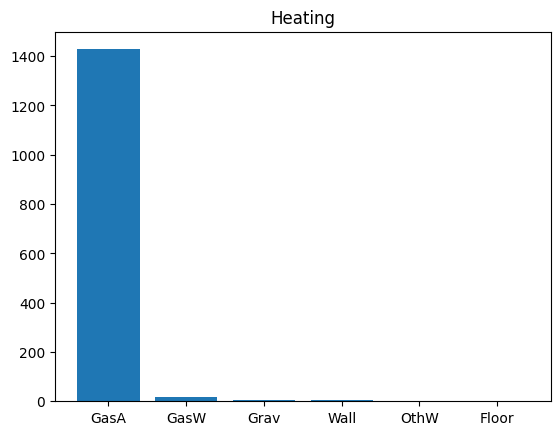

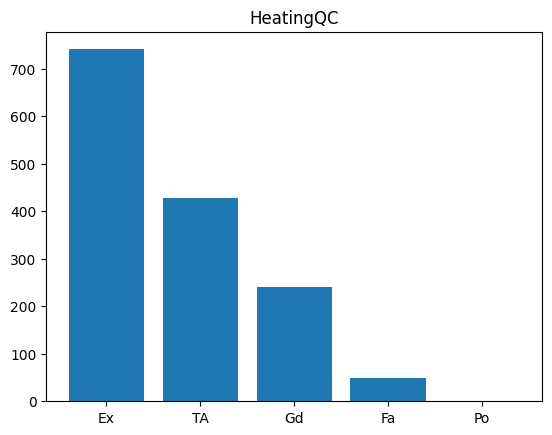

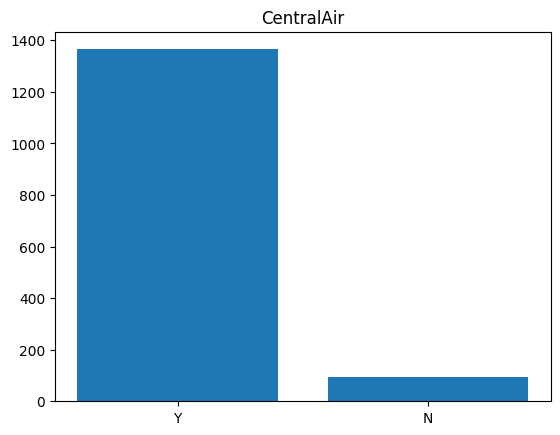

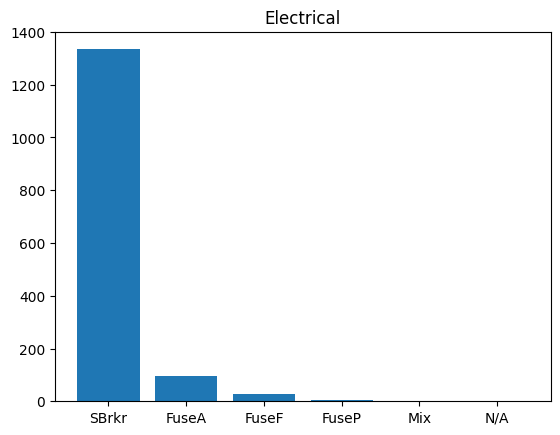

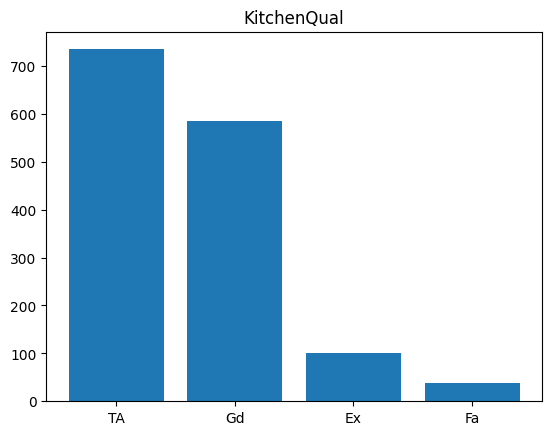

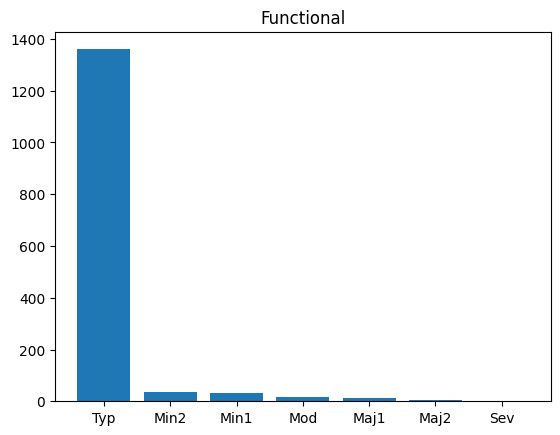

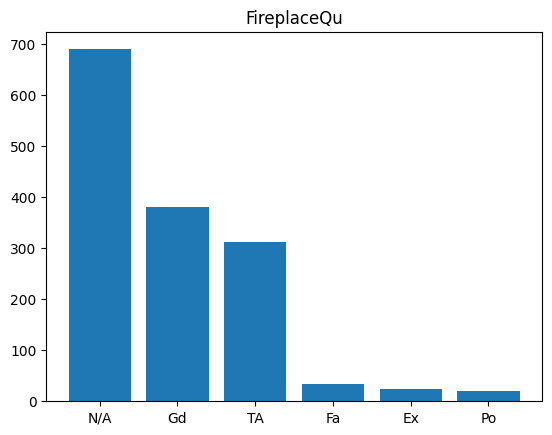

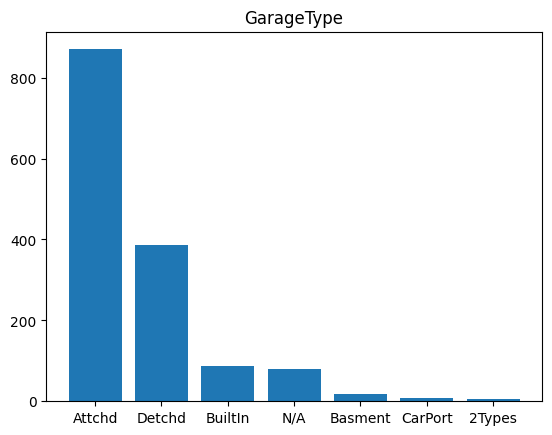

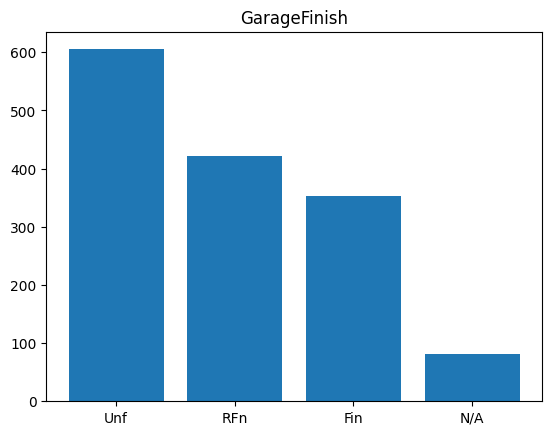

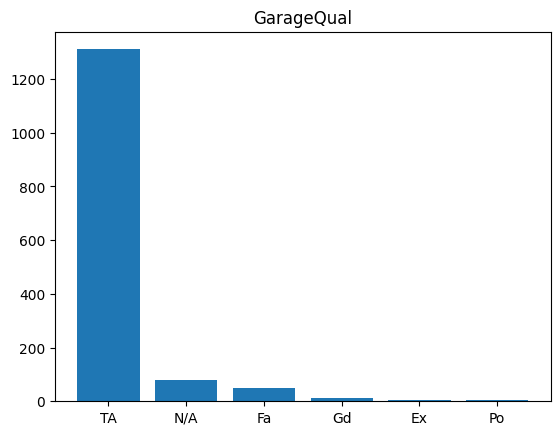

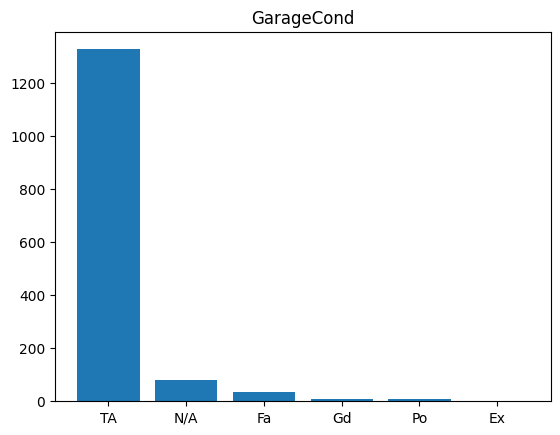

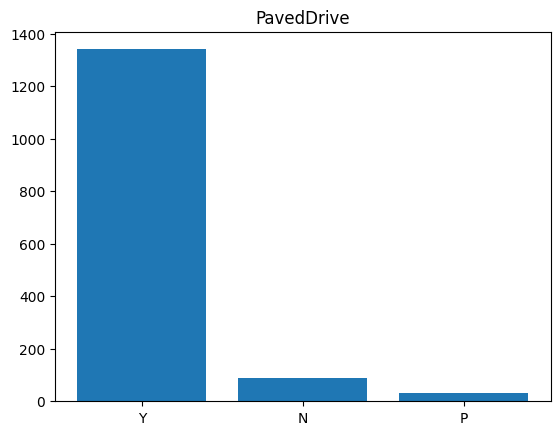

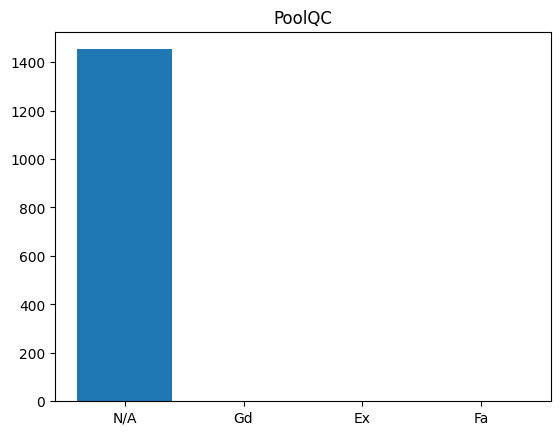

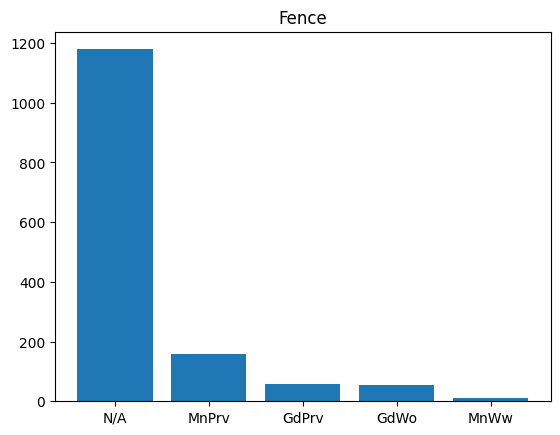

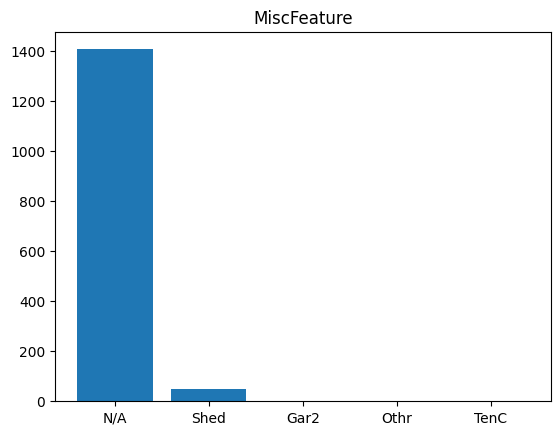

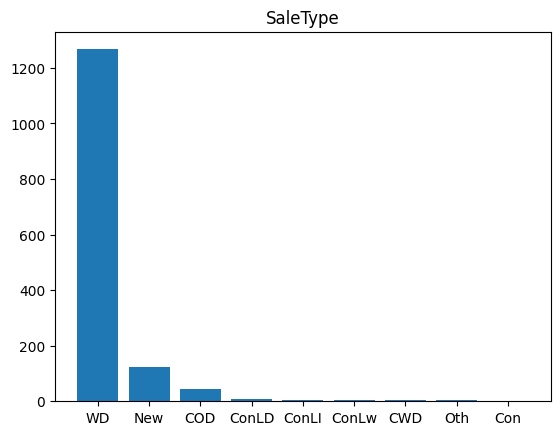

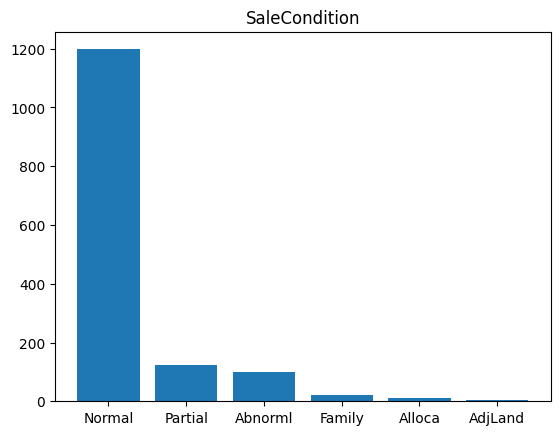

In [ ]:
for col in cat_cols:
  plt.bar(data[col].value_counts().index, data[col].value_counts())
  plt.title(col)
  plt.show()

**Analysis of the above distributions:**

Neighborhoods, Condition1, Condition2 are reliant on local (Iowa) information. Should be removed prior to final model.

Utilities could have been useful, but has too uneven of a distribution.

In [ ]:
# # Dropping features dependent on this specific dataset (i.e. not generalizable)
# data.drop(['Neighborhood', 'Condition1', 'Condition2', 'Utilities', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'], axis=1, inplace=True)

# # Resplitting numerical from categorical features
# X_train = data.drop(['SalePrice'], axis=1)
# cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
# num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

### Numerical Noisy Feature Analysis

In [ ]:
# prompt: remove SalesPrice from X_train adn save it in y_train,split categorical and numerical feature from X_train data. now find correlation of all features in numerical data as compared to y_train, from x_train remove all features with low correlation from X_train
numerical_features = num_cols

# Separate labels from samples
y_train = data['SalePrice']

# Find and graph correlation between all features and the labels
targ_corr_num = {}
for feature in numerical_features:
  # Setting zeros in feature to NaN
  updated_data = cp.deepcopy(data[feature].replace(0, np.nan))

  # Calculate correlation without zeros
  pearson_woz = updated_data.corr(y_train)
  spearman_woz = updated_data.corr(y_train, method='spearman')

  # Calculate correlation with zeros
  pearson_wz = data[feature].corr(y_train)
  spearman_wz = data[feature].corr(y_train, method='spearman')

  # Save correlation into array
  targ_corr_num[feature] = (pearson_wz,spearman_wz, pearson_woz, spearman_woz)

# Observe features and remove using threshold on array
noisy_numerical_strong = []
noisy_numerical_weak = []
for feature in targ_corr_num:
  with_zero = False
  without_zero = False

  # Determining impact of inclusion/exclusion of zeros
  if(abs(targ_corr_num[feature][0]) < 0.3 and abs(targ_corr_num[feature][1]) < 0.3):
    with_zero = True
  if(abs(targ_corr_num[feature][2]) < 0.3 and abs(targ_corr_num[feature][3]) < 0.3):
    without_zero = True

  # Separating features by strong or weak impact of zeros
  if with_zero and without_zero:
    noisy_numerical_strong.append(feature)
  elif (not with_zero and without_zero) or (with_zero and not without_zero):
    noisy_numerical_weak.append(feature)

# Printing strong and weak noisy features
for feature in noisy_numerical_strong:
  print(feature, targ_corr_num[feature])
print("-------------------------------------------------------------------")
for feature in noisy_numerical_weak:
  print(feature, targ_corr_num[feature])

# Setting only to strong noise for now
noisy_numerical = noisy_numerical_strong

print(noisy_numerical)

MSSubClass (-0.08428413512659531, 0.007192252911733476, -0.08428413512659531, 0.007192252911733476)
OverallCond (-0.07785589404867803, -0.12932494660061317, -0.07785589404867803, -0.12932494660061317)
BsmtFinSF2 (-0.011378121450215125, -0.03880613204589418, 0.19895609430836594, 0.11843388567766258)
BsmtUnfSF (0.21447910554696892, 0.185196629420762, 0.1692610004951418, 0.11282241442039748)
BsmtFullBath (0.22712223313149382, 0.22512486719612368, 0.01143916334040866, 0.024792357595010216)
BsmtHalfBath (-0.016844154297359016, -0.012188876310787316, -0.028834567185481722, -0.016703554806725977)
BedroomAbvGr (0.16821315430073988, 0.23490671789027862, 0.18093669310848812, 0.24029795563186981)
KitchenAbvGr (-0.13590737084214122, -0.1648257549850205, -0.1392006921778579, -0.16924325951926172)
EnclosedPorch (-0.12857795792595653, -0.2183936205521982, 0.24127883630117508, 0.24740585729184555)
3SsnPorch (0.04458366533574846, 0.06544021620062833, 0.06393243256889079, 0.2291441132422282)
MiscVal (-0

In [ ]:
# for col in numerical_features:
#   if (col not in noisy_numerical_strong) and (col not in noisy_numerical_weak):
#     plt.scatter(data[col], y_train)
#     plt.title(col)
#     plt.show()
# print("-------------------------------------------------------------------")
# for col in noisy_numerical_strong:
#   plt.scatter(data[col], y_train)
#   plt.title(col)
#   plt.show()
# print("-------------------------------------------------------------------")
# for col in noisy_numerical_weak:
#   plt.scatter(data[col], y_train)
#   plt.title(col)
#   plt.show()

**Analysis of the above**

Halfbath may not be correctly indicative of real-world since higher half-bath count would typically lead to higher prices. However, this could be due to absense of full bathrooms?

Garage Cars may also be fairly noisy, but it may be that more rural homes have higher amount of cars instead.

YearBuilt and YearRemodAdd may both be too far in the past to utilize (right?)
____________________________________________

MsSubClass is more categorical and shouldn't be unincluded from the dataset due to a numerical correlation assumption.

Overall Condition looks more linear.

Year-sold won't be very applicable to the model that we are planning on training.

### Categorical Noisy Feature Analysis

In [ ]:
# For categorical features
categorical_features = cat_cols
targ_corr_cat = {}

for feature in categorical_features:
  # Group the target variable by the categorical feature
  grouped_target = y_train.groupby(data[feature])

  # Perform ANOVA
  f_statistic, p_value = f_oneway(*[grouped_target.get_group(group) for group in grouped_target.groups])

  # Save results
  targ_corr_cat[feature] = (f_statistic, p_value)

# Observe features and remove using a threshold on p-value
noisy_categorical = []
for feature in targ_corr_cat:
  if targ_corr_cat[feature][1] > 0.01:  # Adjust threshold as needed
    print(feature, targ_corr_cat[feature])
    noisy_categorical.append(feature)
print(noisy_categorical)

Street (2.4592895583691994, 0.11704860406782483)
Utilities (0.29880407484898486, 0.5847167739689381)
LandSlope (1.9588170374149438, 0.1413963584114019)
Condition2 (2.0738986215227877, 0.043425658360948464)
MiscFeature (2.593622339924057, 0.0350036718754261)
['Street', 'Utilities', 'LandSlope', 'Condition2', 'MiscFeature']


In [ ]:
# for col in categorical_features:
#   if col not in noisy_categorical:
#     plt.scatter(data[col].astype(str), y_train)
#     plt.title(col)
#     plt.show()
# print("-------------------------------------------------------------------")
# for col in noisy_categorical:
#   plt.scatter(data[col].astype(str), y_train)
#   plt.title(col)
#   plt.show()

**Analysis of the above**

Electrical does have one NaN point that will need to be handled.

GarageCond and GarageQual appear to not be indicative of the "real-world."

Fence does not appear to be a very good distribution.

____________________________________________

Land Slope appears to be informative despite being considered "noise."

### Feature vs Feature Analysis

In [ ]:
# Split numerical from categorical features
# cat_cols = data.select_dtypes(include=['object']).columns.tolist()
# num_cols = data.select_dtypes(include=['number']).columns.tolist()

# Create copies of lists for tracking
cat_cols_copy = cp.deepcopy(cat_cols)
num_cols_copy = cp.deepcopy(num_cols)

# Dictionaries for tracking results
cat_corr = {}
num_corr = {}

In [ ]:
# Use chi-squared analysis on categorical features
for col1 in cat_cols:
  for col2 in cat_cols_copy:

    # No need to compare the same feature
    if col1 == col2:
      continue

    # Contingency table
    contingency_tbl = pd.crosstab(data[col1], data[col2])

    # Ensure table has values (i.e. is not empty)
    if contingency_tbl.size == 0:
      # Assigning default values
      cat_corr[(col1, col2)] = (0, 1)
      continue

    # Perform chi-squared analysis
    chi, p, dof, expected = chi2_contingency(contingency_tbl)

    # Save results
    cat_corr[(col1, col2)] = (chi, p)

  # Remove col from copied list
  if col1 in cat_cols_copy:
    cat_cols_copy.remove(col1)

In [ ]:
# dependent categorical features
for key1,key2 in cat_corr:
  if cat_corr[key1,key2][1] == 0.0:
    print(key1,key2, cat_corr[key1,key2])

MSZoning Neighborhood (2486.263987999627, 0.0)
Neighborhood Exterior2nd (2543.991276041277, 0.0)
Exterior1st Exterior2nd (11868.678367195604, 0.0)
Foundation BsmtQual (1664.4943148860546, 0.0)
BsmtQual BsmtCond (1631.9724267986735, 0.0)
BsmtQual BsmtExposure (1596.1099051272488, 0.0)
BsmtQual BsmtFinType1 (1960.385537564252, 0.0)
BsmtExposure BsmtFinType1 (1608.3712506742656, 0.0)
BsmtFinType1 BsmtFinType2 (1775.454707221523, 0.0)
GarageType GarageFinish (2068.5422757051683, 0.0)
GarageFinish GarageQual (1531.0202997120914, 0.0)
GarageFinish GarageCond (1517.9040342335852, 0.0)
GarageQual GarageCond (3633.062233479517, 0.0)
SaleType SaleCondition (1652.6750772643866, 0.0)


**Creating groupings**:

SaleType concat with SaleCondition

Garage data

Basement data

Exteriors

(Neighborhood gets dropped in feature selection and can be ignored)

In [ ]:
# Use correlation analysis on numerical features
for col1 in num_cols:
  for col2 in num_cols_copy:

    # No need to compare the same feature
    if col1 == col2:
      continue

    # Calculate correlation
    pearson_temp = data[col1].corr(data[col2])
    spearman_temp = data[col1].corr(data[col2], method='spearman')

    # Save correlation into array
    num_corr[(col1, col2)] = (pearson_temp, spearman_temp)

  # Remove col from copied list
  if col1 in num_cols_copy:
    num_cols_copy.remove(col1)

In [ ]:
# redundant numerical features
for key1,key2 in num_corr:
  if num_corr[key1,key2][1] >= 0.85:
    print(key1,key2, num_corr[key1,key2])

YearBuilt GarageYrBlt (0.825667484174342, 0.8905463872089356)
GarageCars GarageArea (0.8824754142814625, 0.8533173766076401)


## Feature Selection

In [ ]:
# Removing the redudant columns (i.e. are not generalizable outside of dataset)
redundant_column = ['Neighborhood', 'Condition1', 'Condition2', 'Utilities', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

# Removing highly correlated columns (that only require one combination of features)
high_corr_column = ['Exterior1st', 'SaleType', 'GarageCars']

column_names_to_remove = redundant_column + noisy_numerical + noisy_categorical + high_corr_column

# Assuming 'data' is your pandas DataFrame
data_copy = data.copy()  # Create a copy of the dataframe to avoid modifying the original
for column_name in column_names_to_remove:
  if column_name in data_copy.columns:
    data_copy = data_copy.drop(column_name, axis=1)
  if column_name in cat_cols:
    cat_cols.remove(column_name)
  if column_name in num_cols:
    num_cols.remove(column_name)

print(data_copy.columns)

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'BldgType', 'HouseStyle', 'OverallQual',
       'RoofStyle', 'RoofMatl', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch',
       'PoolArea', 'PoolQC', 'Fence', 'SaleCondition', 'SalePrice'],
      dtype='object')


In [ ]:
cat_cols_test = data_copy.select_dtypes(include=['object']).columns.tolist()
num_cols_test = data_copy.select_dtypes(include=['number']).columns.tolist()

In [ ]:
num_cols_test

['LotFrontage',
 'LotArea',
 'OverallQual',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'ScreenPorch',
 'PoolArea',
 'SalePrice']

## Feature Engineering

### Numerical Feature Combinations

### Categorical Feature Combinations

In [ ]:
# Combining basement quality features
features_to_combine = ['BsmtQual', 'BsmtCond', 'BsmtExposure']
mapping = {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Mn": 2, "Po": 1, "No": 1, "NA": 0, "N/A": 0}
data_copy[features_to_combine] = data_copy[features_to_combine].replace(mapping)

data_copy["BsmtRating"]= data_copy[features_to_combine].apply(
    lambda x: (x['BsmtQual'] + 5 - x["BsmtCond"]) + x["BsmtExposure"],axis=1)
data_copy.drop(features_to_combine, axis=1, inplace=True)

In [ ]:
def preprocessing(df):
  data_copy = df.copy()
  # Combining basement quality features
  features_to_combine1 = ['BsmtQual', 'BsmtCond', 'BsmtExposure']
  mapping1 = {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Mn": 2, "Po": 1, "No": 1, "NA": 0, "N/A": 0}
  data_copy[features_to_combine1] = data_copy[features_to_combine1].replace(mapping1)

  data_copy["BsmtRating"]= data_copy[features_to_combine1].apply(
      lambda x: (x['BsmtQual'] + 5 - x["BsmtCond"]) + x["BsmtExposure"],axis=1)
  data_copy.drop(features_to_combine1, axis=1, inplace=True)

  # Combining basement finish type features
  features_to_combine2 = ['BsmtFinType1', 'BsmtFinType2']
  mapping2 = {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0, "N/A": 0}
  data_copy[features_to_combine2] = data_copy[features_to_combine2].replace(mapping2)

  data_copy["BsmtFinType"]= data_copy[features_to_combine2].apply(
      lambda x: (x['BsmtFinType1'] + x["BsmtFinType2"]),axis=1)
  data_copy.drop(features_to_combine2, axis=1, inplace=True)

  # Combining garage quality features
  features_to_combine3 = ['GarageQual', 'GarageCond']
  mapping3 = {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Mn": 2, "Po": 1, "No": 1, "NA": 0, "N/A": 0}
  data_copy[features_to_combine3] = data_copy[features_to_combine3].replace(mapping3)

  data_copy["GarageRating"]= data_copy[features_to_combine3].apply(
      lambda x: (x['GarageQual'] + 5 - x["GarageCond"]),axis=1)
  data_copy.drop(features_to_combine3, axis=1, inplace=True)

  # Combining garage type features
  features_to_combine4 = ['GarageType', 'GarageFinish']

  data_copy["GarageInfo"]= data_copy[features_to_combine4].apply(
      lambda x: (x['GarageType'] + "-" + x["GarageFinish"]),axis=1)
  data_copy.drop(features_to_combine4, axis=1, inplace=True)

  cat_cols = data_copy.select_dtypes(include=['object']).columns.tolist()
  num_cols = data_copy.select_dtypes(include=['number']).columns.tolist()

  # Encode categorical features using LabelEncoder
  encoded_data = cp.deepcopy(data_copy)
  encoder_list = {}
  for col in cat_cols:

    # Encoding with rank order
    if "Ex" in encoded_data[col].unique() or "TA" in encoded_data[col].unique() or "Gd" in encoded_data[col].unique():
      mapping = {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Mn": 2, "Po": 1, "No": 1, "NA": 0, "N/A": 0}
      encoded_data[col] = encoded_data[col].replace(mapping)

    else:
      encoder_list1 = joblib.load('encoder_list.pkl')
      encoder = encoder_list1[col]
      encoded_data[col] = encoder.transform(encoded_data[col])

  X_scaler = joblib.load('X_scaler.pkl')
  num_cols_norm = X_scaler.transform(encoded_data[num_cols])
  num_df = pd.DataFrame(num_cols_norm, columns=num_cols)

  # Replace the original numerical columns with normalized ones
  for col in num_cols:
    encoded_data[col] = num_df[col]

  return encoded_data

In [ ]:
# Combining basement finish type features
features_to_combine = ['BsmtFinType1', 'BsmtFinType2']
mapping = {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0, "N/A": 0}
data_copy[features_to_combine] = data_copy[features_to_combine].replace(mapping)

data_copy["BsmtFinType"]= data_copy[features_to_combine].apply(
    lambda x: (x['BsmtFinType1'] + x["BsmtFinType2"]),axis=1)
data_copy.drop(features_to_combine, axis=1, inplace=True)

In [ ]:
# Combining garage quality features
features_to_combine = ['GarageQual', 'GarageCond']
mapping = {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Mn": 2, "Po": 1, "No": 1, "NA": 0, "N/A": 0}
data_copy[features_to_combine] = data_copy[features_to_combine].replace(mapping)

data_copy["GarageRating"]= data_copy[features_to_combine].apply(
    lambda x: (x['GarageQual'] + 5 - x["GarageCond"]),axis=1)
data_copy.drop(features_to_combine, axis=1, inplace=True)

In [ ]:
# Combining garage type features
features_to_combine = ['GarageType', 'GarageFinish']

data_copy["GarageInfo"]= data_copy[features_to_combine].apply(
    lambda x: (x['GarageType'] + "-" + x["GarageFinish"]),axis=1)
data_copy.drop(features_to_combine, axis=1, inplace=True)

In [ ]:
# # Split numerical and categorical features
cat_cols = data_copy.select_dtypes(include=['object']).columns.tolist()
# num_cols = data_copy.select_dtypes(include=['number']).columns.tolist()

# Encode categorical features using LabelEncoder
encoded_data = cp.deepcopy(data_copy)
encoder_list = {}
for col in cat_cols:

  # Encoding with rank order
  if "Ex" in encoded_data[col].unique() or "TA" in encoded_data[col].unique() or "Gd" in encoded_data[col].unique():
    mapping = {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Mn": 2, "Po": 1, "No": 1, "NA": 0, "N/A": 0}
    encoded_data[col] = encoded_data[col].replace(mapping)

    # Adding col to encoder_list, using None for easy detection later on
    encoder_list[col] = None

  # Encoding normally
  else:
    encoder = LabelEncoder()
    encoder.fit(encoded_data[col])
    encoded_data[col] = encoder.transform(encoded_data[col])
    encoder_list[col] = encoder



# Testing that the rank mapping was applied
# print(encoded_data['GarageCond'].unique())

# Testing the label encoding
# print(encoded_data['BldgType'].unique())

In [ ]:
joblib.dump(encoder_list, 'encoder_list.pkl')

['encoder_list.pkl']

In [ ]:
encoded_data

,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,BldgType,HouseStyle,OverallQual,...,ScreenPorch,PoolArea,PoolQC,Fence,SaleCondition,SalePrice,BsmtRating,BsmtFinType,GarageRating,GarageInfo
0,3,65.0,8450,1,3,3,4,0,5,7,...,0,0,0,4,4,208500,7,7,5,4
1,3,80.0,9600,1,3,3,2,0,2,6,...,0,0,0,4,4,181500,10,6,5,4
2,3,68.0,11250,1,0,3,4,0,5,7,...,0,0,0,4,4,223500,8,7,5,4
3,3,60.0,9550,1,0,3,0,0,5,7,...,0,0,0,4,0,140000,5,6,5,15
4,3,84.0,14260,1,0,3,2,0,5,8,...,0,0,0,4,4,250000,9,7,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,62.0,7917,1,3,3,4,0,5,6,...,0,0,0,4,4,175000,7,2,5,4
1456,3,85.0,13175,1,3,3,4,0,2,6,...,0,0,0,2,4,210000,7,8,5,5
1457,3,66.0,9042,1,3,3,4,0,5,7,...,0,0,0,0,4,266500,5,7,5,4
1458,3,68.0,9717,1,3,3,4,0,2,5,...,0,0,0,4,4,142125,7,9,5,5


## Training Models

In [ ]:
# Separate features and target
X = encoded_data.drop('SalePrice', axis=1)
y = encoded_data['SalePrice']

# Normalize numerical features
X_scaler = StandardScaler()
X_scaler.fit(X)
num_cols_norm = X_scaler.transform(X)
num_df = pd.DataFrame(num_cols_norm, columns=num_cols)

# Replace the original numerical columns with normalized ones
for col in num_cols:
  X[col] = num_df[col]

In [ ]:
joblib.dump(X_scaler, 'X_scaler.pkl')

['X_scaler.pkl']

In [ ]:
# Normalize target feature
y_scaler = StandardScaler()
y_scaler.fit(y.values.reshape(-1, 1))
y_norm = y_scaler.transform(y.values.reshape(-1, 1)) # Reshape y to a 2D array
y_df = pd.DataFrame(y_norm, columns=['SalePrice']) # Use y_norm for the DataFrame
y = y_df['SalePrice']

In [ ]:
joblib.dump(y_scaler, 'y_scaler.pkl')

['y_scaler.pkl']

In [ ]:
# # prompt: train a pca to extract significant features

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# X.fillna(0, inplace=True)

# # Apply PCA
# pca = PCA(n_components="mle")  # Keep enough components to explain 95% of variance

# X_pca = pca.fit_transform(X)

# # Plot cumulative explained variance
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.show()

In [ ]:
# print("Number of principal components:", pca.n_components_)

# # Calculate feature importance based on absolute values of PCA components
# feature_importance = np.abs(pca.components_)

# # Get indices that would sort the features by importance
# sorted_idx = np.argsort(feature_importance.sum(axis=0))[::-1]

# # Print feature names in order of importance
# for i in sorted_idx:
#     print(X.columns[i])
print(len(X.columns))
print(X.columns)

48
Index(['MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'BldgType', 'HouseStyle', 'OverallQual',
       'RoofStyle', 'RoofMatl', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtFinSF1', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'SaleCondition',
       'BsmtRating', 'BsmtFinType', 'GarageRating', 'GarageInfo'],
      dtype='object')


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Creating model
lin_model = LinearRegression()

# Using GridSearch to tune the linear regression model
param_grid = {'copy_X': [True, False],
              'fit_intercept': [True, False],
              'n_jobs': [1, 2, 5, 10, 15, None],
              'positive': [True, False]}

lin_cv = GridSearchCV(lin_model, param_grid, cv=5, scoring='neg_mean_squared_error')
lin_cv.fit(X_train, y_train)

# Printing the best results
print(f"Best Hyperparameters: {lin_cv.best_params_}")

# Printing the training score
print(f"Best Score: {lin_cv.best_score_}")

# Scoring test set
print(f"Test Score: {lin_cv.score(X_test, y_test)}")

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'positive': True}
Best Score: -0.28460689408770423
Test Score: -0.2044984025849035


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_base.py", line 647, in fit
    self.coef_ = optimize.nnls(X, y)[0]
  File "/usr/local/lib/python3.10/dist-p

In [ ]:
# Getting test predictions
y_pred = lin_cv.predict(X_test)

# Evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Obtaining RMSE in more interpretable terms
unscaled_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
unscaled_actual = y_scaler.inverse_transform(y_test.values.reshape(-1, 1))
unscaled_rmse = np.sqrt(mean_squared_error(unscaled_actual, unscaled_pred))
print("Unscaled RMSE:", unscaled_rmse)

RMSE: 0.452214995975259
Unscaled RMSE: 35912.78590063204


In [ ]:
joblib.dump(lin_cv, 'lin_cv.pkl')

['lin_cv.pkl']

In [ ]:
lin_cv.feature_names_in_

array(['MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'BldgType', 'HouseStyle',
       'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch',
       'PoolArea', 'PoolQC', 'Fence', 'SaleCondition', 'BsmtRating',
       'BsmtFinType', 'GarageRating', 'GarageInfo'], dtype=object)

In [ ]:
# prompt: change the column order in certain way

new_column_order = ['LotArea', 'OverallQual', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'BsmtRating', 'BsmtFinType', 'GarageRating', 'GarageInfo', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'PavedDrive', 'SaleCondition', 'SalePrice']

# Rearrange the columns in the DataFrame based on the new order
data_copy = data_copy.reindex(columns=new_column_order)

print(data_copy.columns)


,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,BldgType,HouseStyle,OverallQual,...,OpenPorchSF,ScreenPorch,PoolArea,PoolQC,Fence,SaleCondition,BsmtRating,BsmtFinType,GarageRating,GarageInfo
0,3,0.357167,-0.210750,1,3,3,4,0,2,-0.071836,...,-0.704483,-0.270208,-0.068692,0,2,4,6,7,5,4
1,3,1.165191,0.174303,1,0,3,0,0,5,1.374795,...,-0.221343,-0.270208,-0.068692,0,4,4,10,7,5,4
2,4,-0.046845,-0.156028,0,3,3,4,0,2,-0.795151,...,-0.704483,-0.270208,-0.068692,0,4,4,6,2,5,15
3,4,-0.219993,-0.552908,1,3,3,0,0,0,-0.071836,...,-0.342128,-0.270208,-0.068692,0,4,4,6,6,5,15
4,3,0.905469,0.238646,1,0,1,4,0,2,2.098110,...,-0.704483,-0.270208,-0.068692,0,4,4,11,7,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,3,0.357167,-0.234603,1,3,3,4,0,2,-0.795151,...,-0.704483,-0.270208,-0.068692,0,4,4,6,4,5,4
434,4,-0.248851,-0.470726,1,3,3,4,0,2,-2.241782,...,0.775134,-0.270208,-0.068692,0,4,4,6,6,4,5
435,1,0.212877,-0.239714,1,3,3,4,0,5,0.651479,...,-0.704483,-0.270208,-0.068692,0,4,4,7,2,5,4
436,3,0.270593,0.184125,0,3,3,0,0,0,-0.071836,...,-0.009969,-0.270208,-0.068692,0,0,4,8,2,5,15
